![MLComp](https://raw.githubusercontent.com/catalyst-team/catalyst-pics/master/pics/MLcomp.png)
![Catalyst](https://raw.githubusercontent.com/catalyst-team/catalyst-pics/master/pics/catalyst_logo.png)

This kernel demonstrates:

1. Results of training models with [the training kernel](https://www.kaggle.com/lightforever/severstal-mlcomp-catalyst-train-0-90672-offline) and achieves 0.90672 score on public LB

2. Useful code in MLComp library: TtaWrapp, ImageDataset, ChannelTranspose, rle utilities

3. Output statistics and basic visualization

Approach descripton:

1. Segmentation via 3 Unet networks. The predictions are being averaged. 

2. Thresholding and removeing small areas. This method gives 0.90672 on public LB.

**Improving**:

1. As many participations have seen, that is the key to remove false positives from your predictions.

2. To cope with that, a classification network may be used. 

3. Heng CherKeng posted a classifier here: https://www.kaggle.com/c/severstal-steel-defect-detection/discussion/106462#latest-634450 resent34_cls_01, **if you remove false positives with it you should get 0.9117 on LB**

About the libraries:

1. [MLComp](https://github.com/catalyst-team/mlcomp) is a distributed DAG  (Directed acyclic graph)  framework for machine learning with UI. It helps to train, manipulate, and visualize. All models in this kernel were trained offline via MLComp + Catalyst libraries. 

You can control an execution process via Web-site

Dags
![Dags](https://github.com/catalyst-team/mlcomp/blob/master/docs/imgs/dags.png?raw=true)

Computers
![Computers](https://github.com/catalyst-team/mlcomp/blob/master/docs/imgs/computers.png?raw=true)

Reports
![Reports](https://github.com/catalyst-team/mlcomp/blob/master/docs/imgs/reports.png?raw=true)

Code
![Code](https://github.com/catalyst-team/mlcomp/blob/master/docs/imgs/code.png?raw=true)

Please follow [the web site](https://github.com/catalyst-team/mlcomp) to get the details.

https://github.com/catalyst-team/mlcomp

2. Catalys: High-level utils for PyTorch DL & RL research. It was developed with a focus on reproducibility, fast experimentation and code/ideas reusing. Being able to research/develop something new, rather then write another regular train loop. Break the cycle - use the Catalyst!

https://github.com/catalyst-team/catalyst

Docs and examples
- Detailed [classification tutorial](https://github.com/catalyst-team/catalyst/blob/master/examples/notebooks/classification-tutorial.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/catalyst-team/catalyst/blob/master/examples/notebooks/classification-tutorial.ipynb)
- Comprehensive [classification pipeline](https://github.com/catalyst-team/classification).

API documentation and an overview of the library can be found here
[![Docs](https://img.shields.io/badge/dynamic/json.svg?label=docs&url=https%3A%2F%2Fpypi.org%2Fpypi%2Fcatalyst%2Fjson&query=%24.info.version&colorB=brightgreen&prefix=v)](https://catalyst-team.github.io/catalyst/index.html)

In [1]:
! ls ../input/severstalmodels

resnet34_classify.pth  unet_resnet34.pth
unet_mobilenet2.pth    unet_se_resnext50_32x4d.pth


### Install MLComp library(offline version):

As the competition does not allow commit with the kernel that uses internet connection, we use offline installation

In [2]:
! python ../input/mlcomp/mlcomp/mlcomp/setup.py

finished = 1 failed = 0
finished = 4 failed = 0
finished = 8 failed = 0
finished = 9 failed = 0
finished = 10 failed = 0
finished = 11 failed = 0
finished = 13 failed = 0
finished = 14 failed = 0
finished = 19 failed = 0
finished = 23 failed = 0
finished = 26 failed = 0
INSTALLATION SUCCESS


### Import required libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
import matplotlib.pyplot as plt

import numpy as np
import cv2
import albumentations as A
from tqdm import tqdm_notebook
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.jit import load

from mlcomp.contrib.transform.albumentations import ChannelTranspose
from mlcomp.contrib.dataset.classify import ImageDataset
from mlcomp.contrib.transform.rle import rle2mask, mask2rle
from mlcomp.contrib.transform.tta import TtaWrap

### Load models

Catalyst allows to trace models. That is an extremely useful features in Pytorch since 1.0 version: 

https://pytorch.org/docs/stable/jit.html

Now we can load models without re-defining them

In [4]:
unet_se_resnext50_32x4d = \
    load('/kaggle/input/severstalmodels/unet_se_resnext50_32x4d.pth').cuda()
unet_mobilenet2 = load('/kaggle/input/severstalmodels/unet_mobilenet2.pth').cuda()
unet_resnet34 = load('/kaggle/input/severstalmodels/unet_resnet34.pth').cuda()

### Models' mean aggregator

In [5]:
class Model:
    def __init__(self, models):
        self.models = models
    
    def __call__(self, x):
        res = []
        x = x.cuda()
        with torch.no_grad():
            for m in self.models:
                res.append(m(x))
        res = torch.stack(res)
        return torch.mean(res, dim=0)

model = Model([unet_se_resnext50_32x4d, unet_mobilenet2, unet_resnet34])

### Create TTA transforms, datasets, loaders

In [6]:
def create_transforms(additional):
    res = list(additional)
    # add necessary transformations
    res.extend([
        A.Normalize(
            mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
        ),
        ChannelTranspose()
    ])
    res = A.Compose(res)
    return res

img_folder = '/kaggle/input/severstal-steel-defect-detection/test_images'
batch_size = 2
num_workers = 0

# Different transforms for TTA wrapper
transforms = [
    [],
    [A.HorizontalFlip(p=1)]
]

transforms = [create_transforms(t) for t in transforms]
datasets = [TtaWrap(ImageDataset(img_folder=img_folder, transforms=t), tfms=t) for t in transforms]
loaders = [DataLoader(d, num_workers=num_workers, batch_size=batch_size, shuffle=False) for d in datasets]

### Loaders' mean aggregator

In [7]:
thresholds = [0.5, 0.5, 0.5, 0.5]
min_area = [600, 600, 1000, 2000]

res = []
# Iterate over all TTA loaders
total = len(datasets[0])//batch_size
for loaders_batch in tqdm_notebook(zip(*loaders), total=total):
    preds = []
    image_file = []
    for i, batch in enumerate(loaders_batch):
        features = batch['features'].cuda()
        p = torch.sigmoid(model(features))
        # inverse operations for TTA
        p = datasets[i].inverse(p)
        preds.append(p)
        image_file = batch['image_file']
    
    # TTA mean
    preds = torch.stack(preds)
    preds = torch.mean(preds, dim=0)
    preds = preds.detach().cpu().numpy()
    
    # Batch post processing
    for p, file in zip(preds, image_file):
        file = os.path.basename(file)
        # Image postprocessing
        for i in range(4):
            p_channel = p[i]
            imageid_classid = file+'_'+str(i+1)
            p_channel = (p_channel>thresholds[i]).astype(np.uint8)
            if p_channel.sum() < min_area[i]:
                p_channel = np.zeros(p_channel.shape, dtype=p_channel.dtype)

            res.append({
                'ImageId_ClassId': imageid_classid,
                'EncodedPixels': mask2rle(p_channel)
            })
        
df = pd.DataFrame(res)
df.to_csv('submission.csv', index=False)	

Save predictions

In [8]:
df = pd.DataFrame(res)
df = df.fillna('')
df.to_csv('submission.csv', index=False)

Histogram of predictions

In [9]:
df['Image'] = df['ImageId_ClassId'].map(lambda x: x.split('_')[0])
df['Class'] = df['ImageId_ClassId'].map(lambda x: x.split('_')[1])
df['empty'] = df['EncodedPixels'].map(lambda x: not x)
df[df['empty'] == False]['Class'].value_counts()

3    709
4    112
1     77
2      7
Name: Class, dtype: int64

### Visualization

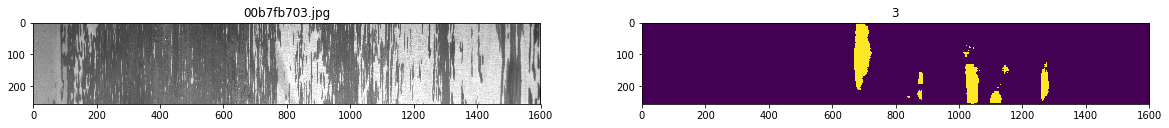

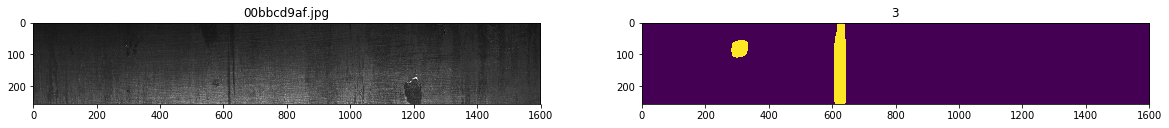

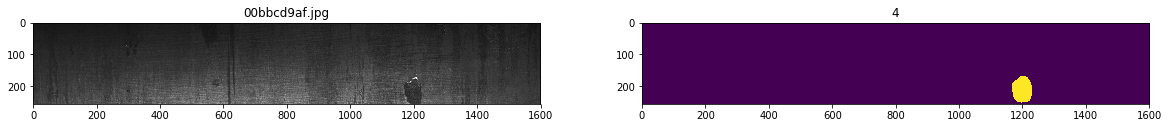

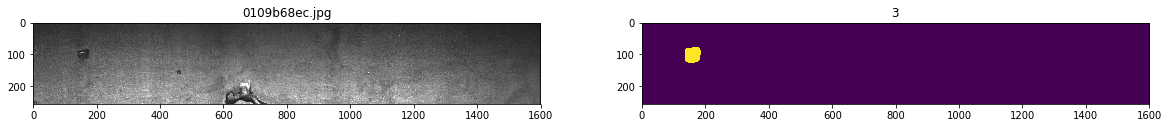

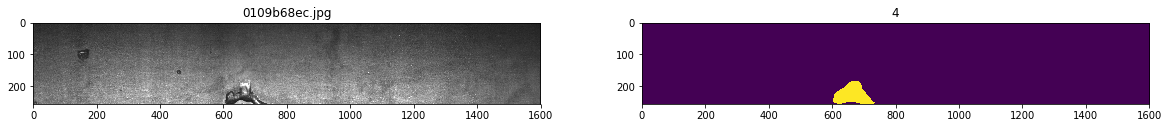

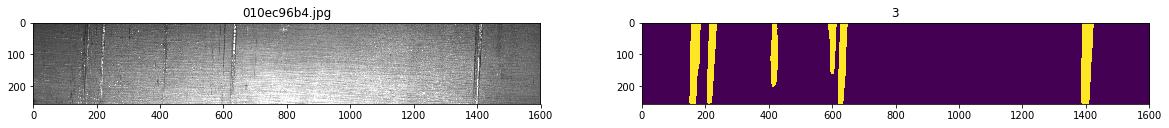

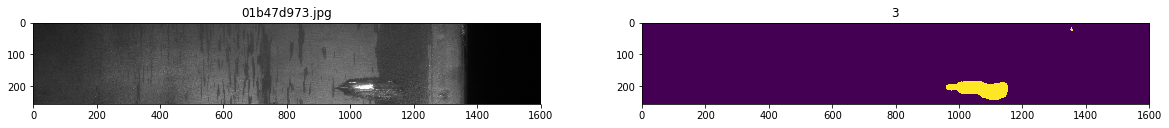

In [10]:
%matplotlib inline

df = pd.read_csv('submission.csv')[:40]
df['Image'] = df['ImageId_ClassId'].map(lambda x: x.split('_')[0])
df['Class'] = df['ImageId_ClassId'].map(lambda x: x.split('_')[1])

for row in df.itertuples():
    img_path = os.path.join(img_folder, row.Image)
    img = cv2.imread(img_path)
    mask = rle2mask(row.EncodedPixels, (1600, 256)) \
        if isinstance(row.EncodedPixels, str) else np.zeros((256, 1600))
    if mask.sum() == 0:
        continue
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 60))
    axes[0].imshow(img/255)
    axes[1].imshow(mask*60)
    axes[0].set_title(row.Image)
    axes[1].set_title(row.Class)
    plt.show()